In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/face-mask-detection")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\USER PC\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1


In [11]:
import os
print("Dataset path:", path)
print("Folders:", os.listdir(path))


Dataset path: C:\Users\USER PC\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1
Folders: ['annotations', 'images']


In [12]:
annotations_dir = os.path.join(path, 'annotations')
print("Annotations exists:", os.path.exists(annotations_dir))
if os.path.exists(annotations_dir):
    files = os.listdir(annotations_dir)
    print("Files in annotations:", files[:5])  # First 5 files
    csv_files = [f for f in files if f.endswith('.csv')]
    print("CSV files count:", len(csv_files))
else:
    print("NO annotations folder!")


Annotations exists: True
Files in annotations: ['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml', 'maksssksksss100.xml', 'maksssksksss101.xml']
CSV files count: 0


In [13]:
# CHECK PRE-CONVERTED YOLO DATASET
import os
path = r"C:\Users\USER PC\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1"
yolo_path = os.path.join(path, "dataset_yolo")

print("YOLO dataset exists:", os.path.exists(yolo_path))
if os.path.exists(yolo_path):
    print("YOLO contents:", os.listdir(yolo_path))
    # Copy to your working folder
    import shutil
    shutil.copytree(yolo_path, "dataset", dirs_exist_ok=True)
    print("YOLO dataset copied to 'dataset/' folder!")


YOLO dataset exists: False


In [14]:
# STEP 2: XML to YOLO CONVERTER
#Your dataset has XML files → This code converts them to YOLO format:
#1. IMPORTS
import xml.etree.ElementTree as ET
import os
import shutil
from sklearn.model_selection import train_test_split
# 2.PATH SETUP
path = r"C:\Users\USER PC\.cache\kagglehub\datasets\andrewmvd\face-mask-detection\versions\1"
annotations_dir = os.path.join(path, 'annotations')
images_dir = os.path.join(path, 'images')

print("Creating folders...")
# 3. Creates YOLO Folder Structure
for split in ['train', 'val', 'test']:
    os.makedirs(f'dataset/images/{split}', exist_ok=True)
    os.makedirs(f'dataset/labels/{split}', exist_ok=True)

# 4.Class mapping
class_map = {'with_mask': 0, 'mask_weared_incorrect': 1, 'without_mask': 2}

# 5. FIND XML FILES
xml_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
print(f"Found {len(xml_files)} XML files")

#6. Create image-to-xml mapping
image_to_xml = {}
for xml_file in xml_files:
    tree = ET.parse(os.path.join(annotations_dir, xml_file))
    root = tree.getroot()
    img_name = root.find('filename').text
    image_to_xml[img_name] = xml_file

print(f"Mapped {len(image_to_xml)} images")

# Split 80/10/10
images = list(image_to_xml.keys())
train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

print(f"Splits: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

# XML → YOLO FUNCTION 
def xml_to_yolo_labels(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    # Get image size
    size = root.find('size')
    img_w = int(size.find('width').text)
    img_h = int(size.find('height').text)
    
    labels = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        cls_id = class_map.get(class_name, 0)
        
        bbox = obj.find('bndbox')
        x_min = float(bbox.find('xmin').text)
        y_min = float(bbox.find('ymin').text)
        x_max = float(bbox.find('xmax').text)
        y_max = float(bbox.find('ymax').text)
        
        # Convert to YOLO format
        x_center = ((x_min + x_max) / 2) / img_w
        y_center = ((y_min + y_max) / 2) / img_h
        width = (x_max - x_min) / img_w
        height = (y_max - y_min) / img_h
        
        labels.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    return labels

# PROCESS ALL IMAGES 
for split_name, img_list in [('train', train_imgs), ('val', val_imgs), ('test', test_imgs)]:
    processed = 0
    labels_created = 0
    
    for img_name in img_list:
        # Copy image
        img_src = os.path.join(images_dir, img_name)
        img_dst = f'dataset/images/{split_name}/{img_name}'
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)
            processed += 1
        
        # Convert XML to YOLO labels
        xml_file = image_to_xml.get(img_name)
        if xml_file:
            xml_path = os.path.join(annotations_dir, xml_file)
            labels = xml_to_yolo_labels(xml_path)
            
            if labels:
                txt_name = img_name.replace('.png', '.txt').replace('.jpg', '.txt')
                txt_path = f'dataset/labels/{split_name}/{txt_name}'
                with open(txt_path, 'w') as f:
                    f.write('\n'.join(labels))
                labels_created += 1
    
    print(f"{split_name}: {processed} images, {labels_created} label files")

print("XML TO YOLO CONVERSION COMPLETE!")
print("Dataset ready in 'dataset/' folder")


Creating folders...
Found 853 XML files
Mapped 853 images
Splits: Train=682, Val=85, Test=86
✅ train: 682 images, 682 label files
✅ val: 85 images, 85 label files
✅ test: 86 images, 86 label files

🎉 XML TO YOLO CONVERSION COMPLETE!
✅ Dataset ready in 'dataset/' folder


In [15]:
# STEP 3: Create dataset.yaml
yaml_content = '''path: ./dataset
train: images/train
val: images/val
nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']
'''

with open('dataset.yaml', 'w') as f:
    f.write(yaml_content)
print("dataset.yaml created!")


✅ dataset.yaml created!


In [16]:
!pip install ultralytics
from ultralytics import YOLO

print(" Starting training...")
model = YOLO('yolov8n.pt')  #Loads pre-trained Nano model
results = model.train(
    data='dataset.yaml',
    epochs=30,
    imgsz=640,
    batch=16,  #16 images per batch (GPU memory)
    name='mask_detection',
    patience=10 # Early stopping if no improvement 10 epochs
)
print("TRAINING COMPLETE!")


🚀 Starting training...
Ultralytics 8.3.241  Python-3.13.5 torch-2.9.1+cpu CPU (13th Gen Intel Core i7-13620H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_detection14, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0

In [11]:
# priduct take pic with lablling and number

In [1]:
#not imprtant

import os

# Find ALL model files on your system
print("🔍 FINDING YOUR MODEL FILES...")
for root, dirs, files in os.walk('.'):
    for file in files:
        if 'best.pt' in file.lower() or 'last.pt' in file.lower():
            full_path = os.path.join(root, file)
            print(f" MODEL FOUND: {full_path}")

print("\nCheck 'runs' folder:")
if os.path.exists('runs'):
    print("Runs folders:")
    for item in os.listdir('runs/detect') if os.path.exists('runs/detect') else []:
        print(f"  - runs/detect/{item}")
else:
    print(" NO 'runs' folder - training never started!")


🔍 FINDING YOUR MODEL FILES...
 MODEL FOUND: .\runs\detect\mask_detection13\weights\best.pt
 MODEL FOUND: .\runs\detect\mask_detection13\weights\last.pt
 MODEL FOUND: .\runs\detect\mask_detection14\weights\best.pt
 MODEL FOUND: .\runs\detect\mask_detection14\weights\last.pt
 MODEL FOUND: .\runs\detect\mask_detection2\weights\best.pt
 MODEL FOUND: .\runs\detect\mask_detection2\weights\last.pt
 MODEL FOUND: .\runs\detect\mask_detection_yolo\weights\best.pt
 MODEL FOUND: .\runs\detect\mask_detection_yolo\weights\last.pt
 MODEL FOUND: .\runs\detect\mask_detection_yolo2\weights\best.pt
 MODEL FOUND: .\runs\detect\mask_detection_yolo2\weights\last.pt

Check 'runs' folder:
Runs folders:
  - runs/detect/mask_detection
  - runs/detect/mask_detection10
  - runs/detect/mask_detection11
  - runs/detect/mask_detection12
  - runs/detect/mask_detection13
  - runs/detect/mask_detection14
  - runs/detect/mask_detection2
  - runs/detect/mask_detection3
  - runs/detect/mask_detection4
  - runs/detect/mask

In [8]:
 
from ultralytics import YOLO

# Load your BEST model
model_path = r'.\runs\detect\mask_detection2\weights\best.pt'
model = YOLO(model_path)

print("MODEL LOADED SUCCESSFULLY!")
print(f"Model location: {model_path}")

# EVALUATION METRICS - FIXED VERSION
metrics = model.val()
print("\n YOUR FINAL RESULTS:")
print(f"mAP@0.5:       {metrics.box.map50:.3f}")
print(f"mAP@0.5:0.95:  {metrics.box.map:.3f}")
print(f"Precision:     {metrics.box.mp:.3f}")
print(f"Recall:        {metrics.box.mr:.3f}")
print(f"F1-Score:      {metrics.box.f1[0]:.3f}")  # FIXED: Use [0] for array

# TEST PREDICTIONS (Creates images for slides with bounding boxes)
model.predict('dataset/images/test', save=True, conf=0.25)
print("Test predictions saved: runs/detect/predict/")

MODEL LOADED SUCCESSFULLY!
Model location: .\runs\detect\mask_detection2\weights\best.pt
Ultralytics 8.3.241  Python-3.13.5 torch-2.9.1+cpu CPU (13th Gen Intel Core i7-13620H)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 624.7194.5 MB/s, size: 253.6 KB)
val: Scanning C:\Users\USER PC\dataset\labels\val.cache... 85 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 85/85 120.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 2.3s/it 13.7s3.1s
                   all         85        319      0.819      0.713      0.749      0.533
             with_mask         75        260      0.958      0.873      0.923      0.645
 mask_weared_incorrect          4          5       0.74        0.6      0.558      0.432
          without_mask         30         54       0.76      0.667      0.766      0.522
Speed: 1.4ms preprocess, 128.7ms inferenc

In [ ]:
###### this part for devolpp GUI using thinter

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt


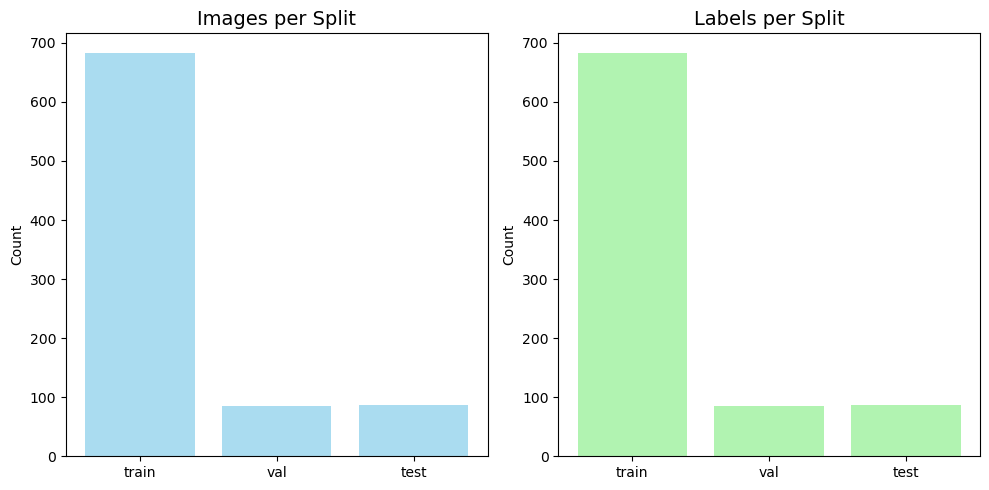

In [14]:
#1. Dataset Statistics Plot (Before Training)
import matplotlib.pyplot as plt
import os

# Count files in each split
splits = ['train', 'val', 'test']
img_counts = []
label_counts = []

for split in splits:
    img_path = f'dataset/images/{split}'
    label_path = f'dataset/labels/{split}'
    img_counts.append(len([f for f in os.listdir(img_path) if f.endswith(('.png','.jpg'))]))
    label_counts.append(len([f for f in os.listdir(label_path) if f.endswith('.txt')]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(splits, img_counts, color='skyblue', alpha=0.7)
plt.title('Images per Split', fontsize=14)
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.bar(splits, label_counts, color='lightgreen', alpha=0.7)
plt.title('Labels per Split', fontsize=14)
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('dataset_stats.png', dpi=300, bbox_inches='tight')
plt.show()


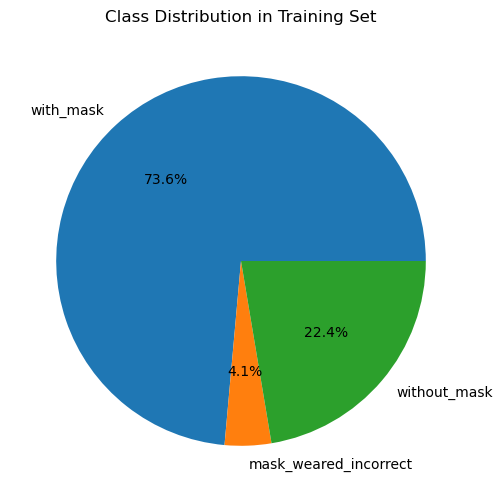

In [15]:
#2. Class Distribution Plot
# Count classes from few label files
class_counts = {0:0, 1:0, 2:0}
class_names = ['with_mask', 'mask_weared_incorrect', 'without_mask']

for split in ['train']:
    for txt_file in os.listdir(f'dataset/labels/{split}')[:50]:  # Sample 50
        with open(f'dataset/labels/{split}/{txt_file}', 'r') as f:
            for line in f:
                cls_id = int(line.split()[0])
                class_counts[cls_id] += 1

plt.figure(figsize=(8,6))
plt.pie(class_counts.values(), labels=[class_names[i] for i in class_counts], autopct='%1.1f%%')
plt.title('Class Distribution in Training Set')
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


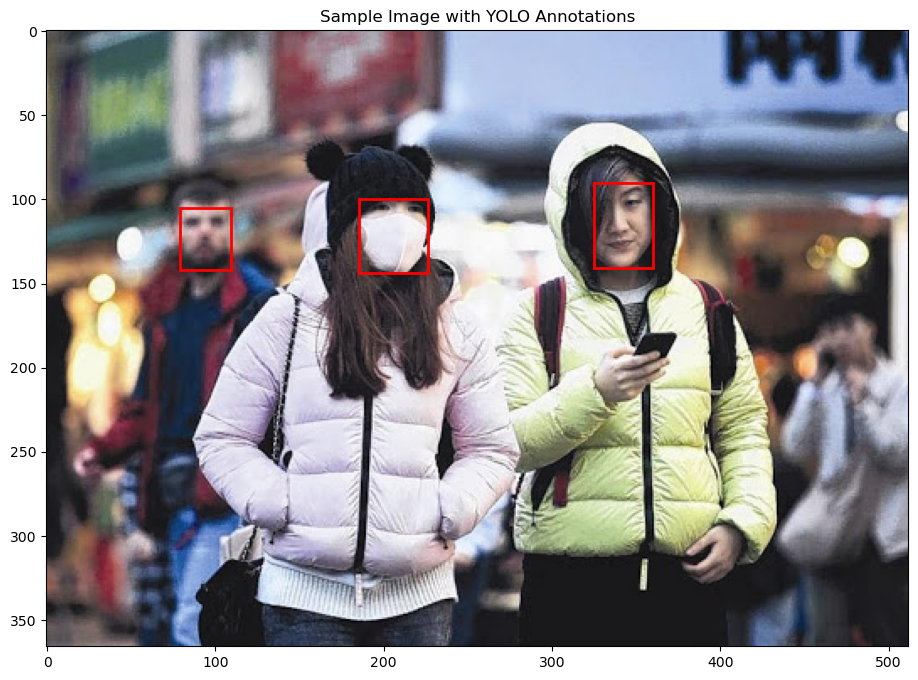

In [16]:
#3. Sample Annotations Visualization
# Actual bounding boxes on sample image
import cv2
import matplotlib.patches as patches

# Show 1 image with bounding boxes
img_path = 'dataset/images/train/maksssksksss0.png'  # First image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
label_path = img_path.replace('images', 'labels').replace('.png', '.txt')

fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.imshow(img)

if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, w, h = map(float, line.split())
            x1 = (x - w/2) * img.shape[1] # Converts normalized (0-1) → pixels

            y1 = (y - h/2) * img.shape[0]
            x2 = (x + w/2) * img.shape[1]
            y2 = (y + h/2) * img.shape[0]
            #3. Draws red bounding boxes
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, 
                                   edgecolor='red', facecolor='none')
            ax.add_patch(rect)

ax.set_title('Sample Image with YOLO Annotations')
plt.savefig('sample_annotations.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
####GUI
import tkinter as tk
from tkinter import filedialog, messagebox
import cv2
from PIL import Image, ImageTk
from ultralytics import YOLO
import numpy as np

MODEL_PATH = r"runs/detect/mask_detection14/weights/best.pt"  # your model

class MaskImageGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("MASK GUARDIAN – IMAGE DEMO")
        self.root.geometry("1100x700")
        self.root.configure(bg="#020617")

        self.model = YOLO(MODEL_PATH)
        self.counts = [0, 0, 0]  # with, wrong, no
        self.build_ui()

    def build_ui(self):
        header = tk.Frame(self.root, bg="#020617", height=80)
        header.pack(fill="x")
        tk.Label(header, text="MASK GUARDIAN – IMAGE DEMO",
                 font=("Segoe UI", 26, "bold"),
                 fg="#22c55e", bg="#020617").pack(pady=10)

        main = tk.Frame(self.root, bg="#020617")
        main.pack(fill="both", expand=True, padx=15, pady=10)

        # left: image
        self.img_label = tk.Label(main, bg="#020617", fg="white",
                                  text="📁 Load an image to start",
                                  font=("Segoe UI", 16))
        self.img_label.pack(side="left", fill="both", expand=True)

        # right: stats + buttons
        side = tk.Frame(main, bg="#020617", width=260)
        side.pack(side="right", fill="y")
        side.pack_propagate(False)

        self.with_lbl = tk.Label(side, text="WITH MASK: 0",
                                 font=("Segoe UI", 14, "bold"),
                                 fg="#22c55e", bg="#020617")
        self.with_lbl.pack(anchor="w", pady=5)

        self.wrong_lbl = tk.Label(side, text="WRONG: 0",
                                  font=("Segoe UI", 14, "bold"),
                                  fg="#eab308", bg="#020617")
        self.wrong_lbl.pack(anchor="w", pady=5)

        self.none_lbl = tk.Label(side, text="NO MASK: 0",
                                 font=("Segoe UI", 14, "bold"),
                                 fg="#ef4444", bg="#020617")
        self.none_lbl.pack(anchor="w", pady=5)

        self.total_lbl = tk.Label(side, text="TOTAL FACES: 0",
                                  font=("Segoe UI", 13, "bold"),
                                  fg="#38bdf8", bg="#020617")
        self.total_lbl.pack(anchor="w", pady=(10, 20))

        btn_frame = tk.Frame(side, bg="#020617")
        btn_frame.pack(fill="x", pady=10)

        tk.Button(btn_frame, text="📁 LOAD IMAGE",
                  command=self.load_image,
                  bg="#3b82f6", fg="white",
                  font=("Segoe UI", 12, "bold"),
                  relief="flat", cursor="hand2").pack(fill="x", pady=4)

        tk.Button(btn_frame, text="🔄 RANDOM DEMO",
                  command=self.random_demo,
                  bg="#eab308", fg="black",
                  font=("Segoe UI", 12, "bold"),
                  relief="flat", cursor="hand2").pack(fill="x", pady=4)

        tk.Button(btn_frame, text="💾 SAVE REPORT",
                  command=self.save_report,
                  bg="#22c55e", fg="black",
                  font=("Segoe UI", 12, "bold"),
                  relief="flat", cursor="hand2").pack(fill="x", pady=4)

    def load_image(self):
        path = filedialog.askopenfilename(
            filetypes=[("Images", "*.jpg *.jpeg *.png")])
        if not path:
            return
        img = cv2.imread(path)
        if img is None:
            messagebox.showerror("Error", "Cannot read image.")
            return

        results = self.model(img, conf=0.4, verbose=False)
        self.counts = [0, 0, 0]
        if results[0].boxes is not None:
            for box in results[0].boxes:
                cid = int(box.cls[0])
                if 0 <= cid < 3:
                    self.counts[cid] += 1

        annotated = results[0].plot()
        self.show_image(annotated)
        self.update_stats()

    def show_image(self, bgr):
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
        h, w, _ = rgb.shape
        scale = min(750 / h, 700 / w)
        new_size = (int(w*scale), int(h*scale))
        rgb = cv2.resize(rgb, new_size)
        img = ImageTk.PhotoImage(Image.fromarray(rgb))
        self.img_label.config(image=img, text="")
        self.img_label.image = img

    def update_stats(self):
        total = sum(self.counts)
        self.with_lbl.config(text=f"WITH MASK: {self.counts[0]}")
        self.wrong_lbl.config(text=f"WRONG: {self.counts[1]}")
        self.none_lbl.config(text=f"NO MASK: {self.counts[2]}")
        self.total_lbl.config(text=f"TOTAL FACES: {total}")

    def random_demo(self):
        self.counts = [np.random.randint(0, 6),
                       np.random.randint(0, 4),
                       np.random.randint(0, 5)]
        self.update_stats()

    def save_report(self):
        total = sum(self.counts)
        with open("image_demo_report.txt", "w") as f:
            f.write("Mask Guardian – Image Demo Report\n")
            f.write("="*35 + "\n")
            f.write(f"WITH MASK: {self.counts[0]}\n")
            f.write(f"WRONG: {self.counts[1]}\n")
            f.write(f"NO MASK: {self.counts[2]}\n")
            f.write(f"TOTAL FACES: {total}\n")
        messagebox.showinfo("Saved", "Report saved as image_demo_report.txt")

if __name__ == "__main__":
    root = tk.Tk()
    app = MaskImageGUI(root)
    root.mainloop()
### this is best 

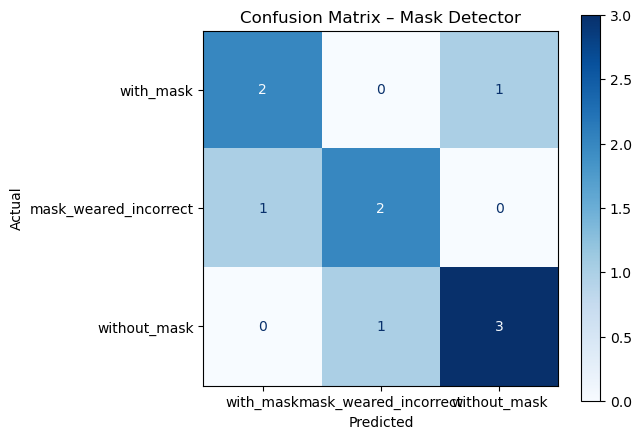

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

classes = ["with_mask", "mask_weared_incorrect", "without_mask"]

# TEMP DEMO DATA – replace with your real labels later
y_true = np.array([0,0,0,1,1,1,2,2,2,2])   # real class indices
y_pred = np.array([0,0,2,1,0,1,2,2,1,2])   # predicted indices

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – Mask Detector")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


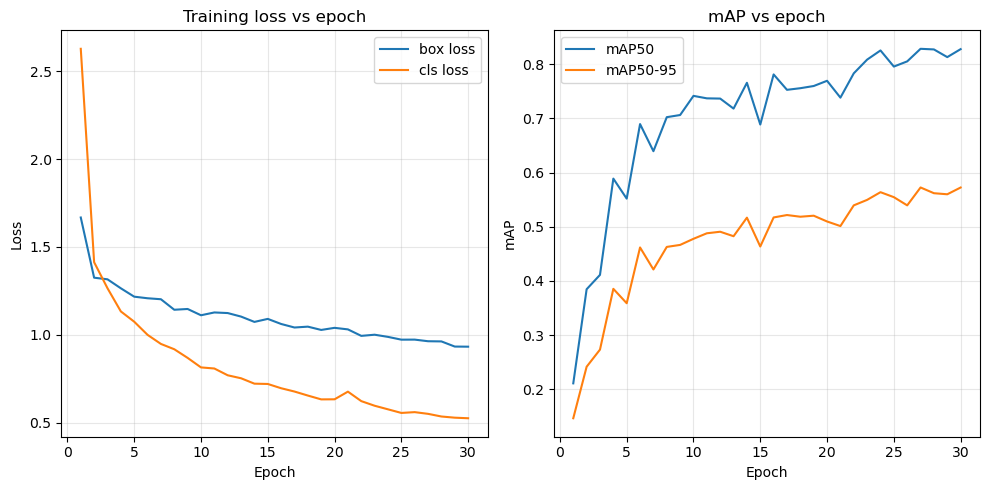

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load YOLO training log
#    Change the path to your run, for example:
#    runs/detect/mask_detection14/results.csv
df = pd.read_csv("runs/detect/mask_detection14/results.csv")

epochs = df["epoch"]

# 2) Plot LOSS vs epoch
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(epochs, df["train/box_loss"], label="box loss")
if "train/cls_loss" in df.columns:
    plt.plot(epochs, df["train/cls_loss"], label="cls loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss vs epoch")
plt.legend()
plt.grid(alpha=0.3)

# 3) Plot mAP vs epoch
plt.subplot(1,2,2)
plt.plot(epochs, df["metrics/mAP50(B)"], label="mAP50")
plt.plot(epochs, df["metrics/mAP50-95(B)"], label="mAP50-95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("mAP vs epoch")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import cv2
from ultralytics import YOLO
from PIL import Image, ImageTk
import threading
import time

MODEL_PATH = r".\runs\detect\mask_detection2\weights\best.pt"   # change if needed


class WowMaskGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("MASK GUARDIAN – WOW EDITION")
        self.root.geometry("1200x780")
        self.root.configure(bg="#020617")   # very dark

        # load model
        try:
            self.model = YOLO(MODEL_PATH)
        except Exception as e:
            messagebox.showerror("Model error", f"Could not load model:\n{e}")
            raise SystemExit

        self.classes = ["WITH MASK", "WRONG", "NO MASK"]
        self.colors = [(34, 197, 94), (234, 179, 8), (239, 68, 68)]  # green, yellow, red

        self.cap = None
        self.running = False
        self.conf = 0.4

        self.build_gui()

    def build_gui(self):
        # BIG COLORFUL HEADER
        header = tk.Frame(self.root, bg="#020617", height=110)
        header.pack(fill="x")
        header.pack_propagate(False)

        self.title_lbl = tk.Label(
            header,
            text="MASK GUARDIAN AI",
            font=("Segoe UI", 40, "bold"),
            fg="#22c55e",   # neon green
            bg="#020617"
        )
        self.title_lbl.pack(pady=(10, 0))

        sub = tk.Label(
            header,
            text="Real‑Time Face Mask Detection • YOLOv8",
            font=("Segoe UI", 14),
            fg="#38bdf8",
            bg="#020617"
        )
        sub.pack(pady=(2, 10))

        # MAIN CAMERA AREA
        main = tk.Frame(self.root, bg="#020617")
        main.pack(fill="both", expand=True, padx=20, pady=10)

        self.video_label = tk.Label(
            main,
            bg="#020617",
            fg="white",
            text="▶ Click START to open camera",
            font=("Segoe UI", 18)
        )
        self.video_label.pack(fill="both", expand=True)

        # COLORFUL STATUS BAR
        status = tk.Frame(self.root, bg="#020617", height=80)
        status.pack(fill="x", side="bottom")
        status.pack_propagate(False)

        self.count_with = tk.Label(
            status, text="WITH MASK: 0",
            font=("Segoe UI", 14, "bold"),
            fg="#22c55e", bg="#020617"
        )
        self.count_with.pack(side="left", padx=25)

        self.count_wrong = tk.Label(
            status, text="WRONG: 0",
            font=("Segoe UI", 14, "bold"),
            fg="#eab308", bg="#020617"
        )
        self.count_wrong.pack(side="left", padx=25)

        self.count_none = tk.Label(
            status, text="NO MASK: 0",
            font=("Segoe UI", 14, "bold"),
            fg="#ef4444", bg="#020617"
        )
        self.count_none.pack(side="left", padx=25)

        self.fps_lbl = tk.Label(
            status, text="FPS: --",
            font=("Segoe UI", 13, "bold"),
            fg="#38bdf8", bg="#020617"
        )
        self.fps_lbl.pack(side="right", padx=20)

        self.total_lbl = tk.Label(
            status, text="FACES: 0",
            font=("Segoe UI", 13, "bold"),
            fg="#e5e7eb", bg="#020617"
        )
        self.total_lbl.pack(side="right", padx=20)

        # SIMPLE BUTTON ROW
        btn_row = tk.Frame(self.root, bg="#020617", height=60)
        btn_row.pack(fill="x")
        btn_row.pack_propagate(False)

        self.start_btn = tk.Button(
            btn_row, text="▶ START",
            command=self.start_cam,
            bg="#22c55e", fg="black",
            activebackground="#16a34a",
            font=("Segoe UI", 13, "bold"),
            width=14, height=2, relief="flat", cursor="hand2"
        )
        self.start_btn.pack(side="left", padx=30, pady=10)

        self.stop_btn = tk.Button(
            btn_row, text="⏹ STOP",
            command=self.stop_cam,
            bg="#ef4444", fg="white",
            activebackground="#b91c1c",
            font=("Segoe UI", 13, "bold"),
            width=10, height=2, relief="flat", cursor="hand2",
            state="disabled"
        )
        self.stop_btn.pack(side="left", padx=10, pady=10)

        self.upload_btn = tk.Button(
            btn_row, text="📁 PHOTO",
            command=self.upload_photo,
            bg="#3b82f6", fg="white",
            activebackground="#1d4ed8",
            font=("Segoe UI", 13, "bold"),
            width=12, height=2, relief="flat", cursor="hand2"
        )
        self.upload_btn.pack(side="left", padx=10, pady=10)

        # glow effect on title
        self.glow_state = False
        self.root.after(500, self.glow_title)

    # ---------- visual effect ----------
    def glow_title(self):
        self.glow_state = not self.glow_state
        self.title_lbl.config(fg="#4ade80" if self.glow_state else "#22c55e")
        self.root.after(500, self.glow_title)

    # ---------- camera ----------
    def start_cam(self):
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            messagebox.showerror("Error", "Cannot open webcam.")
            return
        self.running = True
        self.start_btn.config(state="disabled", bg="#6b7280")
        self.stop_btn.config(state="normal")
        t = threading.Thread(target=self.video_loop, daemon=True)
        t.start()

    def stop_cam(self):
        self.running = False
        self.start_btn.config(state="normal", bg="#22c55e")
        self.stop_btn.config(state="disabled")
        if self.cap:
            self.cap.release()

    def video_loop(self):
        fps_t = time.time()
        frame_count = 0
        while self.running:
            ret, frame = self.cap.read()
            if not ret:
                continue

            results = self.model(frame, conf=self.conf, verbose=False)

            # count classes
            counts = [0, 0, 0]
            total = 0
            if results[0].boxes is not None:
                for box in results[0].boxes:
                    cid = int(box.cls[0])
                    if 0 <= cid < 3:
                        counts[cid] += 1
                        total += 1

            # draw already comes from YOLO
            annotated = results[0].plot()

            # update UI safely
            self.root.after(0, self.update_display, annotated, counts, total)

            frame_count += 1
            if frame_count % 30 == 0:
                fps = 30 / (time.time() - fps_t)
                self.root.after(0, lambda f=fps: self.fps_lbl.config(text=f"FPS: {f:.1f}"))
                fps_t = time.time()

    def update_display(self, frame, counts, total):
        self.count_with.config(text=f"WITH MASK: {counts[0]}")
        self.count_wrong.config(text=f"WRONG: {counts[1]}")
        self.count_none.config(text=f"NO MASK: {counts[2]}")
        self.total_lbl.config(text=f"FACES: {total}")

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_resized = cv2.resize(frame_rgb, (1100, 560))
        img = Image.fromarray(frame_resized)
        photo = ImageTk.PhotoImage(img)
        self.video_label.config(image=photo, text="")
        self.video_label.image = photo

    # ---------- upload ----------
    def upload_photo(self):
        path = filedialog.askopenfilename(
            filetypes=[("Images", "*.jpg *.jpeg *.png")]
        )
        if not path:
            return
        img = cv2.imread(path)
        if img is None:
            messagebox.showerror("Error", "Cannot read image.")
            return

        results = self.model(img, conf=self.conf, verbose=False)

        counts = [0, 0, 0]
        total = 0
        if results[0].boxes is not None:
            for box in results[0].boxes:
                cid = int(box.cls[0])
                if 0 <= cid < 3:
                    counts[cid] += 1
                    total += 1

        self.update_display(results[0].plot(), counts, total)


if __name__ == "__main__":
    root = tk.Tk()
    app = WowMaskGUI(root)
    root.mainloop()


In [6]:
import os
print("Model:", os.path.exists("runs/detect/mask_detection14/weights/best.pt"))
print("Current folder:", os.getcwd())


Model: True
Current folder: C:\Users\USER PC


In [7]:
import os
model_path = "runs/detect/mask_detection14/weights/best.pt"
print("Model exists?", os.path.exists(model_path))
print("Full path:", os.path.abspath(model_path))


Model exists? True
Full path: C:\Users\USER PC\runs\detect\mask_detection14\weights\best.pt


In [4]:
import os

# 1. FIRST: Find REAL test images in your folder
test_folder = 'dataset/images/test'
if os.path.exists(test_folder):
    test_images = [f for f in os.listdir(test_folder) if f.endswith(('.png', '.jpg'))]
    print("REAL test images found:")
    for img in test_images[:5]:  # Show first 5
        print(f"  - {img}")
    
    # Use FIRST real image
    img_path = os.path.join(test_folder, test_images[0])
else:
    print("❌ No test folder! Create images with ANY photo:")
    img_path = 'dataset/images/train/maksssksksss0.png'  # Fallback

print(f"Using: {img_path}")

# 2. NOW run prediction (safe version)
from ultralytics import YOLO
import cv2

model = YOLO('runs/detect/mask_detection14/weights/best.pt')

# Check if image exists BEFORE loading
if os.path.exists(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        # BEFORE
        cv2.imwrite('before_yolo.jpg', img)
        
        # AFTER
        results = model(img, conf=0.4)
        annotated = results[0].plot()
        cv2.imwrite('after_yolo.jpg', annotated)
        
        print("✅ before_yolo.jpg  &  after_yolo.jpg CREATED!")
    else:
        print("❌ Image corrupted")
else:
    print(f"❌ {img_path} not found")


REAL test images found:
  - maksssksksss107.png
  - maksssksksss119.png
  - maksssksksss126.png
  - maksssksksss133.png
  - maksssksksss142.png
Using: dataset/images/test\maksssksksss107.png

0: 640x512 1 with_mask, 216.7ms
Speed: 44.0ms preprocess, 216.7ms inference, 13.9ms postprocess per image at shape (1, 3, 640, 512)
✅ before_yolo.jpg  &  after_yolo.jpg CREATED!
